In [1]:
# import those package we need 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # 引入 tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

Import data

In [2]:
X_train = pd.read_csv("X_train_clean.csv") 
X_test = pd.read_csv("X_test_clean.csv")
y_train = pd.read_csv("y_train_clean.csv")
y_test = pd.read_csv("y_test_clean.csv")

In [3]:
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

lightGBM

In [4]:
# LightGBM

lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, label = y_test, reference = lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
#bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval])
bst = lgb.train(params, lgb_train, num_round, 
                valid_sets = [lgb_train, lgb_eval], 
                callbacks = [lgb.early_stopping(stopping_rounds = 200)]
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 647, number of negative: 6441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091281 -> initscore=-2.298093
[LightGBM] [Info] Start training from score -2.298093
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain,

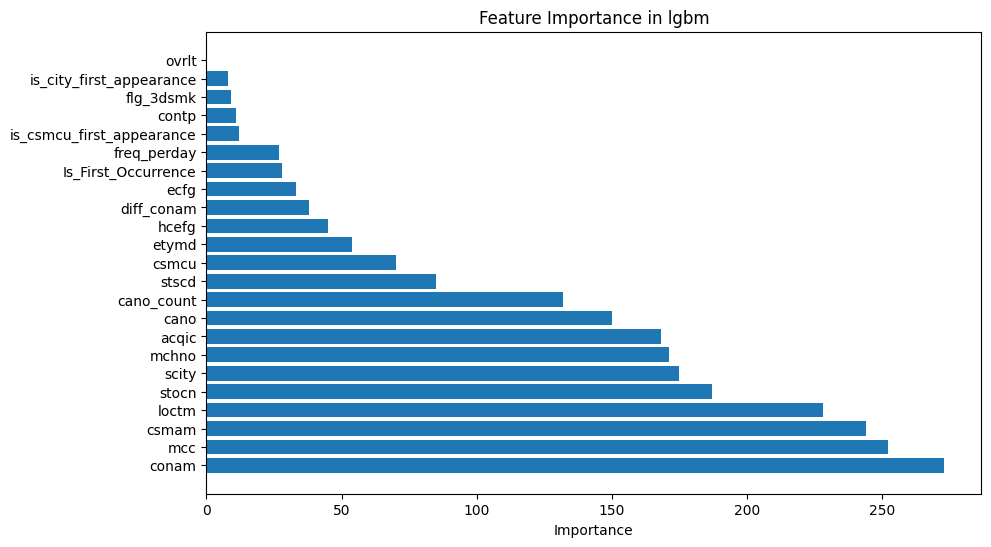

In [5]:
# Light GBM 
feature_importance_in_lgbm = bst.feature_importance(importance_type = 'split')  # 或 'gain'，取決於你想要的類型

# 獲取特徵名稱
feature_names_in_lgbm = bst.feature_name()

# 將特徵重要性轉換為 DataFrame
feature_importance_df_lgbm = pd.DataFrame({'Feature': feature_names_in_lgbm, 
                                           'Importance': feature_importance_in_lgbm}
                                           )

# 依照特徵重要性降序排序
feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values(by = 'Importance', ascending = False)

# 繪製特徵重要性圖表
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df_lgbm['Feature'], 
         feature_importance_df_lgbm['Importance']
         )

plt.xlabel('Importance')
plt.title('Feature Importance in lgbm')
plt.show()

Random forest

In [6]:
# random forest 

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 20231123, 
                                       n_jobs = 12
                                       )
rf_classifier.fit(X_train, y_train)

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=20231123)

In [7]:
# Random forest 
feature_importance_in_rf = rf_classifier.feature_importances_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_in_rf
})

# 將 DataFrame 按照重要性排序
feature_importance_df_rf = feature_importance_df_rf.sort_values(by = 'Importance', ascending = False)

# 繪製條形圖
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color = 'skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # 如果特徵名稱較多，可以旋轉 x 軸標籤
plt.show()

NameError: name 'X' is not defined